In [1]:
# libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# data
from data.data import data
from data.sys_data import sys_data 

# setup
sns.set_theme()

In [2]:
# get data
raw_dataset = data.parse_data('../test_data.txt')
df = pd.DataFrame(raw_dataset)

print("Peak Bandwidth: ", sys_data.peak_theoretical_bandwidth, "GB/s")
print(raw_dataset)

Peak Bandwidth:  42.94967296 GB/s
              name    space           min           max        median  \
0         Sum slow    10000  1.711400e-05  1.142430e-04  1.838100e-05   
1       Sum arrays      400  1.890000e-07  1.809000e-06  2.180000e-07   
2       Sum arrays     4000  1.955000e-06  4.791000e-06  1.987000e-06   
3       Sum arrays    40000  1.952200e-05  2.637800e-05  1.977500e-05   
4  Matrix multiply  4000000  3.031280e-03  5.680770e-03  3.034720e-03   
5   Insertion sort       40  1.290000e-07  3.250000e-07  1.480000e-07   
6   Insertion sort      400  1.141800e-05  3.197200e-05  1.177400e-05   
7   Insertion sort     4000  1.107640e-03  1.587240e-03  1.112730e-03   

           mean            sd            q1            q3  
0  1.892100e-05  4.118110e-06  1.715100e-05  2.078500e-05  
1  2.200480e-07  3.794670e-08  2.160000e-07  2.190000e-07  
2  2.007050e-06  2.346720e-07  1.982000e-06  1.993000e-06  
3  1.993520e-05  3.431280e-06  1.975200e-05  1.983400e-05  
4  3.063

# Write and Read

In [3]:
df_bandwidth = df.loc[df.name =='Insertion sort'].copy()
df_bandwidth['bandwidth'] = \
    df_bandwidth.apply(lambda row: \
        data.effective_bandwidth(row['space'], row['mean'], True) / 1e9, \
    axis=1 \
    )
print(df_bandwidth)

             name  space           min           max        median  \
5  Insertion sort     40  1.290000e-07  3.250000e-07  1.480000e-07   
6  Insertion sort    400  1.141800e-05  3.197200e-05  1.177400e-05   
7  Insertion sort   4000  1.107640e-03  1.587240e-03  1.112730e-03   

           mean            sd            q1            q3  bandwidth  
5  1.479370e-07  8.192120e-09  1.440000e-07  1.510000e-07   0.540771  
6  1.186460e-05  7.463010e-07  1.171300e-05  1.188000e-05   0.067427  
7  1.133610e-03  5.157890e-05  1.110990e-03  1.115880e-03   0.007057  


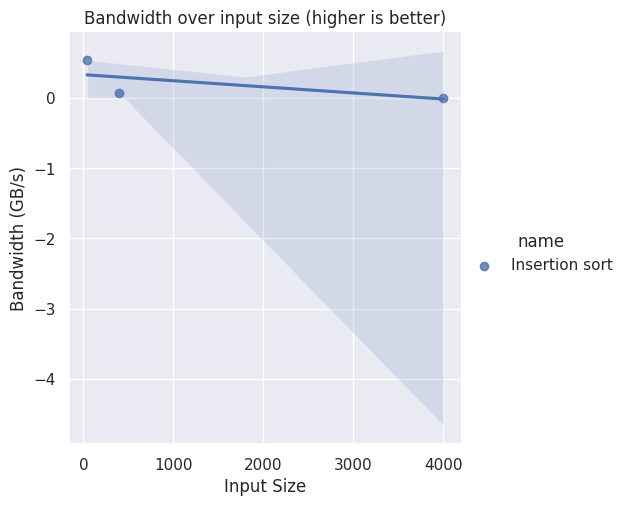

In [4]:
sns.lmplot(
    data=df_bandwidth, hue='name', 
    x="space", y="bandwidth",
)
plt.title('Bandwidth over input size (higher is better)')
plt.xlabel('Input Size')
plt.ylabel('Bandwidth (GB/s)')
plt.show()

# Float sum

In [5]:
df_flops = df.loc[df.name == 'Sum arrays'].copy()
df_flops['bandwidth'] = \
    df_flops.apply(lambda row: \
        data.effective_bandwidth(row.space * 4, row['mean'], True) / 1e9, \
    axis=1 \
    )
print(df_flops)

         name  space           min       max        median          mean  \
1  Sum arrays    400  1.890000e-07  0.000002  2.180000e-07  2.200480e-07   
2  Sum arrays   4000  1.955000e-06  0.000005  1.987000e-06  2.007050e-06   
3  Sum arrays  40000  1.952200e-05  0.000026  1.977500e-05  1.993520e-05   

             sd            q1            q3  bandwidth  
1  3.794670e-08  2.160000e-07  2.190000e-07  14.542282  
2  2.346720e-07  1.982000e-06  1.993000e-06  15.943798  
3  3.431280e-06  1.975200e-05  1.983400e-05  16.052009  


In [6]:
# insert max teoretical bandwidth
df_max = pd.DataFrame({
    'name': [f'theoretical max' for space in df_flops.space.unique()],
    'space': df_flops.space.unique(),
    'bandwidth': sys_data.peak_theoretical_bandwidth # Calculate theoretical max bandwidth
})
df_final = pd.concat([df_flops, df_max])
print(df_final)

              name  space           min       max        median          mean  \
1       Sum arrays    400  1.890000e-07  0.000002  2.180000e-07  2.200480e-07   
2       Sum arrays   4000  1.955000e-06  0.000005  1.987000e-06  2.007050e-06   
3       Sum arrays  40000  1.952200e-05  0.000026  1.977500e-05  1.993520e-05   
0  theoretical max    400           NaN       NaN           NaN           NaN   
1  theoretical max   4000           NaN       NaN           NaN           NaN   
2  theoretical max  40000           NaN       NaN           NaN           NaN   

             sd            q1            q3  bandwidth  
1  3.794670e-08  2.160000e-07  2.190000e-07  14.542282  
2  2.346720e-07  1.982000e-06  1.993000e-06  15.943798  
3  3.431280e-06  1.975200e-05  1.983400e-05  16.052009  
0           NaN           NaN           NaN  42.949673  
1           NaN           NaN           NaN  42.949673  
2           NaN           NaN           NaN  42.949673  


Text(68.774625, 0.5, 'Bandwidth (GB/s)')

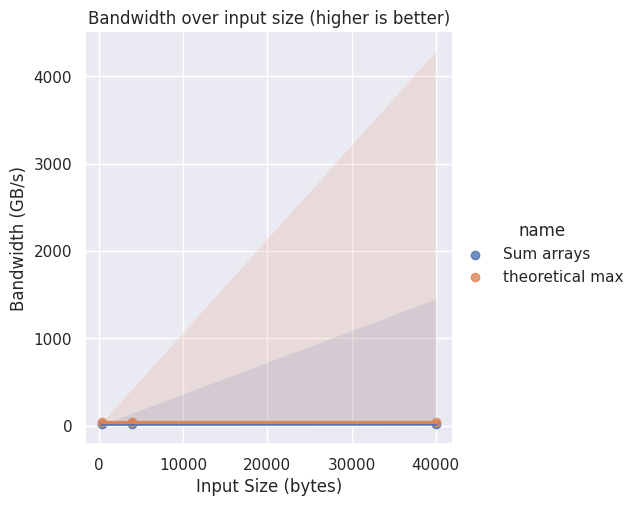

In [7]:
sns.lmplot(
    data=df_final, hue='name', 
    x="space", y="bandwidth",
)
plt.title('Bandwidth over input size (higher is better)')
plt.xlabel('Input Size (bytes)')
plt.ylabel('Bandwidth (GB/s)')

Empty DataFrame
Columns: [name, space, min, max, median, mean, sd, q1, q3, flops]
Index: []


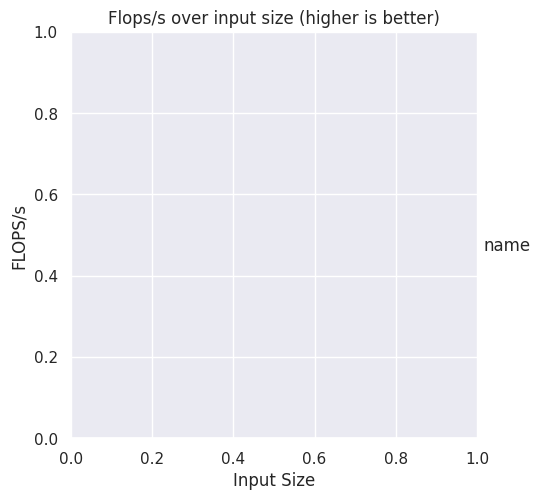

In [8]:
df_flops = df.loc[df.name == 'sum arrays'].copy()
df_flops['flops'] = \
    df_flops.apply(\
        lambda row: \
            data.flopss(row.space, row['mean']), \
        axis=1 \
    )
print(df_flops)

sns.lmplot(
    data=df_flops, hue='name', 
    x="space", y="flops",
)
plt.title('Flops/s over input size (higher is better)')
plt.xlabel('Input Size')
plt.ylabel('FLOPS/s')
plt.show()

# Sequencial vs Random write

In [9]:
df_sequencial = df.loc[df.name.isin(['write serial', 'write random'])].copy()
# multiply the space by sizeof(int) and by two because we are doing reads and writes
df_sequencial['bandwidth'] = \
    df_sequencial.apply(\
        lambda row: \
            data.effective_bandwidth(row.space * 4 * 2, row['mean'], True) / 1e9, \
        axis=1, \
    )
print(df_sequencial)

Empty DataFrame
Columns: [name, space, min, max, median, mean, sd, q1, q3, bandwidth]
Index: []


In [10]:
# insert max teoretical bandwidth
df_max = pd.DataFrame({
    'name': ['theoretical max' for space in df_sequencial.space.unique()],
    'space': df_sequencial.space.unique(),
    'bandwidth': sys_data.peak_theoretical_bandwidth # Calculate theoretical max bandwidth
})
df_sequencial = pd.concat([df_sequencial, df_max])
print(df_sequencial)

Empty DataFrame
Columns: [name, space, min, max, median, mean, sd, q1, q3, bandwidth]
Index: []


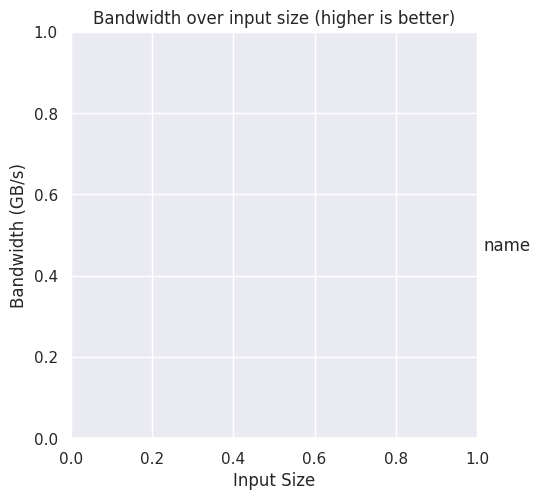

In [11]:
sns.lmplot(
    data=df_sequencial, hue='name', 
    x="space", y="bandwidth",
)
plt.title('Bandwidth over input size (higher is better)')
plt.xlabel('Input Size')
plt.ylabel('Bandwidth (GB/s)')
plt.show()

# Matrix Multiplication

In [12]:
df_mmul = df.loc[df.name == 'Matrix multiply'].copy()
df_mmul['bandwidth'] = \
    df_mmul.apply(\
        lambda row: \
            data.effective_bandwidth(row.space**2 *4, row['mean'], True) / 1e9, \
        axis=1, \
    )
print(df_mmul)

              name    space       min       max    median      mean        sd  \
4  Matrix multiply  4000000  0.003031  0.005681  0.003035  0.003064  0.000222   

         q1        q3     bandwidth  
4  0.003033  0.003037  4.177723e+07  


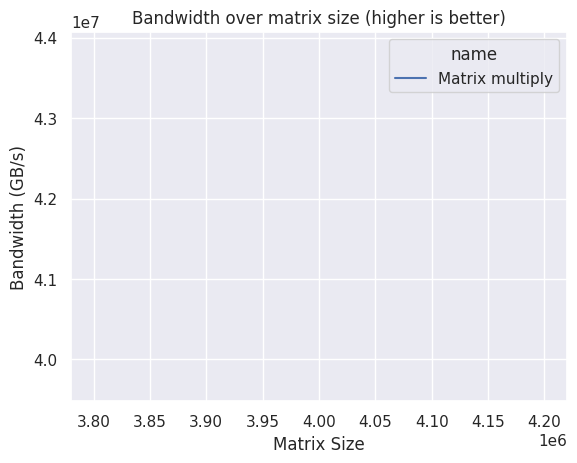

In [13]:
sns.lineplot(
    data=df_mmul, hue='name', 
    x="space", y="bandwidth",
)
plt.title('Bandwidth over matrix size (higher is better)')
plt.xlabel('Matrix Size')
plt.ylabel('Bandwidth (GB/s)')
plt.show()

In [14]:
df_mmul_flops = df.loc[df.name == 'Matrix multiply'].copy()
df_mmul_flops['flops'] = \
    df_mmul_flops.apply(\
        lambda row: \
            data.flopss(row.space**2 * 2, row['mean']),
        axis=1, \
    )
df_mmul_flops.space = \
    df_mmul_flops.apply(\
        lambda row: \
            row.flops / (row.space**3 * 4), \
        axis=1,\
    )
print(df_mmul_flops)

              name     space       min       max    median      mean  \
4  Matrix multiply  0.000041  0.003031  0.005681  0.003035  0.003064   

         sd        q1        q3         flops  
4  0.000222  0.003033  0.003037  1.044431e+16  


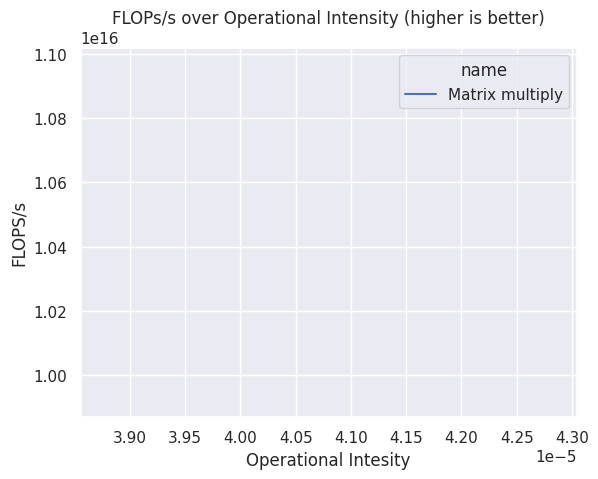

In [15]:
sns.lineplot(
    data=df_mmul_flops, hue='name', 
    x="space", y="flops",
)
plt.title('FLOPs/s over Operational Intensity (higher is better)')
plt.xlabel('Operational Intesity')
plt.ylabel('FLOPS/s')
plt.show()

In [16]:
df_mmul_flops = df.loc[df.name == 'Matrix multiply'].copy()
df_mmul_flops['flops'] = \
    df_mmul_flops.apply(\
        lambda row: \
            data.flopss(row.space**3 * 2, row['mean']),
        axis=1, \
    )
df_mmul_flops.space = \
    df_mmul_flops.apply(\
        lambda row: \
            row.space **2 * 4, \
        axis=1,\
    )
print(df_mmul_flops)

              name           space       min       max    median      mean  \
4  Matrix multiply  64000000000000  0.003031  0.005681  0.003035  0.003064   

         sd        q1        q3         flops  
4  0.000222  0.003033  0.003037  4.177723e+22  


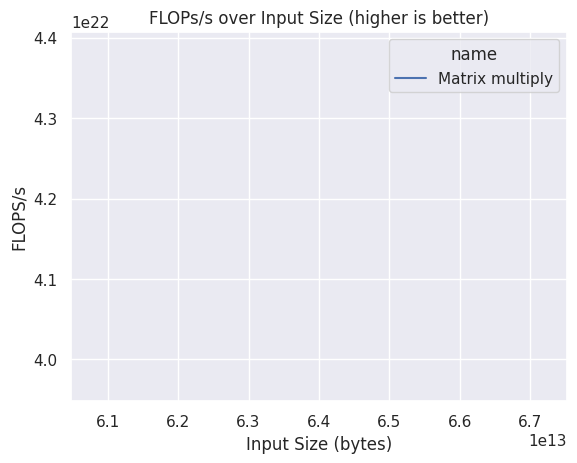

In [17]:
sns.lineplot(
    data=df_mmul_flops, hue='name', 
    x="space", y="flops",
)
plt.title('FLOPs/s over Input Size (higher is better)')
plt.xlabel('Input Size (bytes)')
plt.ylabel('FLOPS/s')
plt.show()